In [1]:
import sys
import operator
import parse as p
import author_network as an
import regression as re
import numpy as np
import networkx as nx
import graphviz as gv
from matplotlib import pyplot as plt
from community import community_louvain
import collections
from node2vec import Node2Vec

### Reading File

In [2]:
#files = ['../data/icml2019.json', '../data/icml2018.json','../data/icml2017.json']
files = ['../data/icml2019.json']
years = '(2019)'

author_list, paper_list = p.parse_json(files)

In [3]:
temp, temp1 = p.get_paper_count(author_list)
authors = temp[0]
counts = temp[1]
sorted_authors = temp1[0]
sorted_counts = temp1[1]

### Author who published the most papers

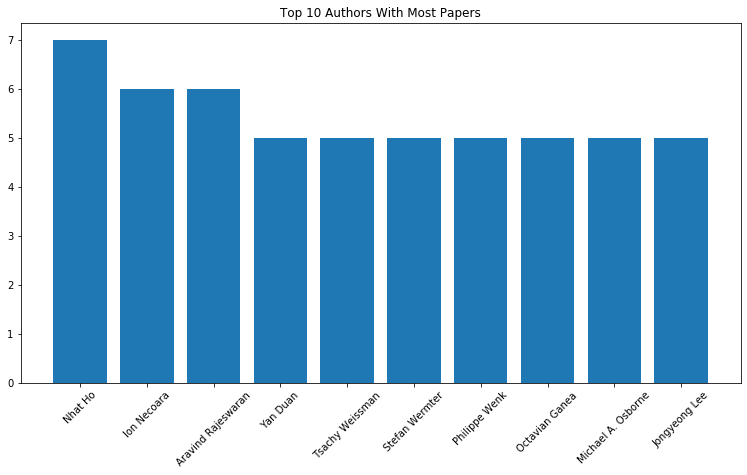

In [4]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_axes([0,0,1,1])
for label in ax.xaxis.get_ticklabels() :
    label.set_rotation(45)
ax.bar(sorted_authors[:10],sorted_counts[:10], width = 0.8)
plt.title('Top 10 Authors With Most Papers')
plt.savefig('../image/authors_with_most_papers'+years+'.pdf', bbox_inches='tight')
plt.show()

###  Author who has been working with the most people

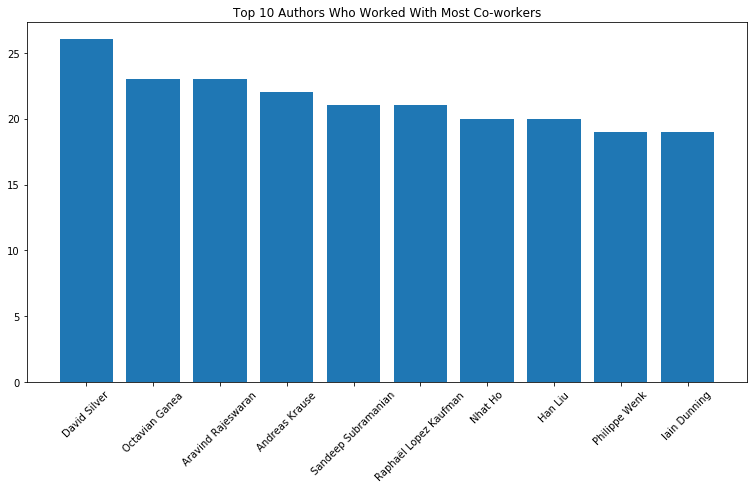

In [5]:
co_count_authors, co_counts = an.co_worker_counts(author_list)
fig = plt.figure(figsize=(10, 5))
ax = fig.add_axes([0,0,1,1])
for label in ax.xaxis.get_ticklabels() :
    label.set_rotation(45)
ax.bar(co_count_authors[:10],co_counts[:10], width = 0.8)
plt.title('Top 10 Authors Who Worked With Most Co-workers')
plt.savefig('../image/authors_working_with_most_people'+years+'.pdf', bbox_inches='tight')
plt.show()

### Community Detection (Louvain algorithm)

In [6]:
edges, alone = an.get_edges(author_list, paper_list)
G = nx.MultiGraph()
G.add_edges_from(edges)
G.add_nodes_from(alone)
partition = community_louvain.best_partition(G)


In [7]:
# Adding number of papers attribute
for i in range(len(authors)):
    G.nodes[authors[i]]['papers'] = counts[i]

In [8]:
values = [partition.get(node) for node in G.nodes()]
counter = collections.Counter(values)

### Author who has been working with the most research groups
### 1) Simply counted version

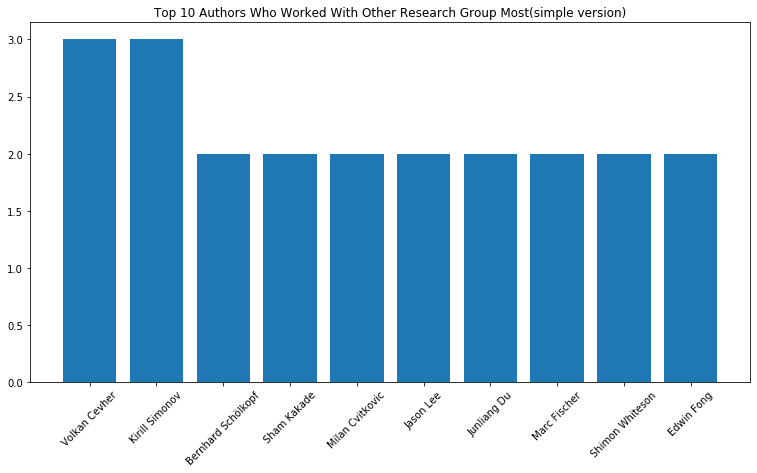

In [9]:
other_group = an.find_other_group(G, values, author_list)
fig = plt.figure(figsize=(10, 5))
ax = fig.add_axes([0,0,1,1])
for label in ax.xaxis.get_ticklabels() :
    label.set_rotation(45)
ax.bar([x[0] for x in other_group ][:10], [x[1] for x in other_group ][:10], width = 0.8)
plt.title('Top 10 Authors Who Worked With Other Research Group Most(simple version)')
plt.savefig('../image/authors_with_most_research_groups_simple'+years+'.pdf', bbox_inches='tight')
plt.show()

### 2) Betweeness centrality

In [10]:
G_b = nx.Graph()
G_b.add_edges_from(edges)
G_b.add_nodes_from(alone)

# Adding number of papers attribute
for i in range(len(authors)):
    G_b.nodes[authors[i]]['papers'] = counts[i]

In [11]:
Cb_dict = nx.betweenness_centrality(G_b)
Cb = sorted(Cb_dict.items(), key=operator.itemgetter(1), reverse = True)

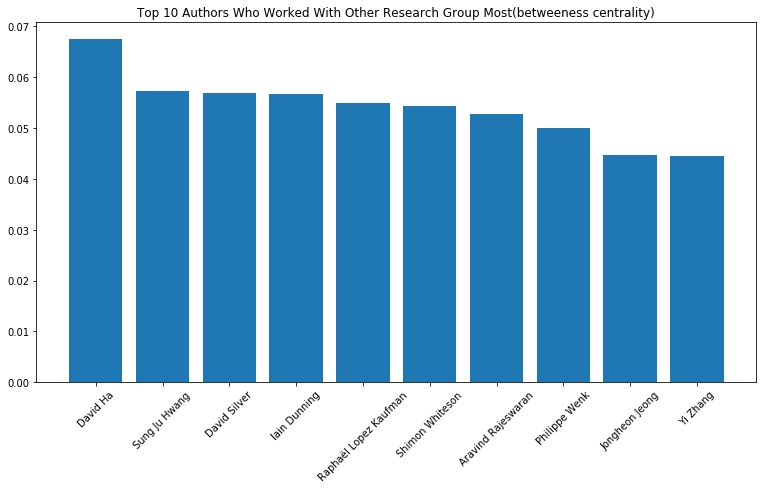

In [12]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_axes([0,0,1,1])
for label in ax.xaxis.get_ticklabels() :
    label.set_rotation(45)
ax.bar([x[0] for x in Cb][:10], [x[1] for x in Cb][:10], width = 0.8)
plt.title('Top 10 Authors Who Worked With Other Research Group Most(betweeness centrality)')
plt.savefig('../image/authors_with_most_research_groups_betweeness'+years+'.pdf', bbox_inches='tight')
plt.show()

### Research groups

In [13]:
total_groups, G_g = an.make_research_groups(G, values)

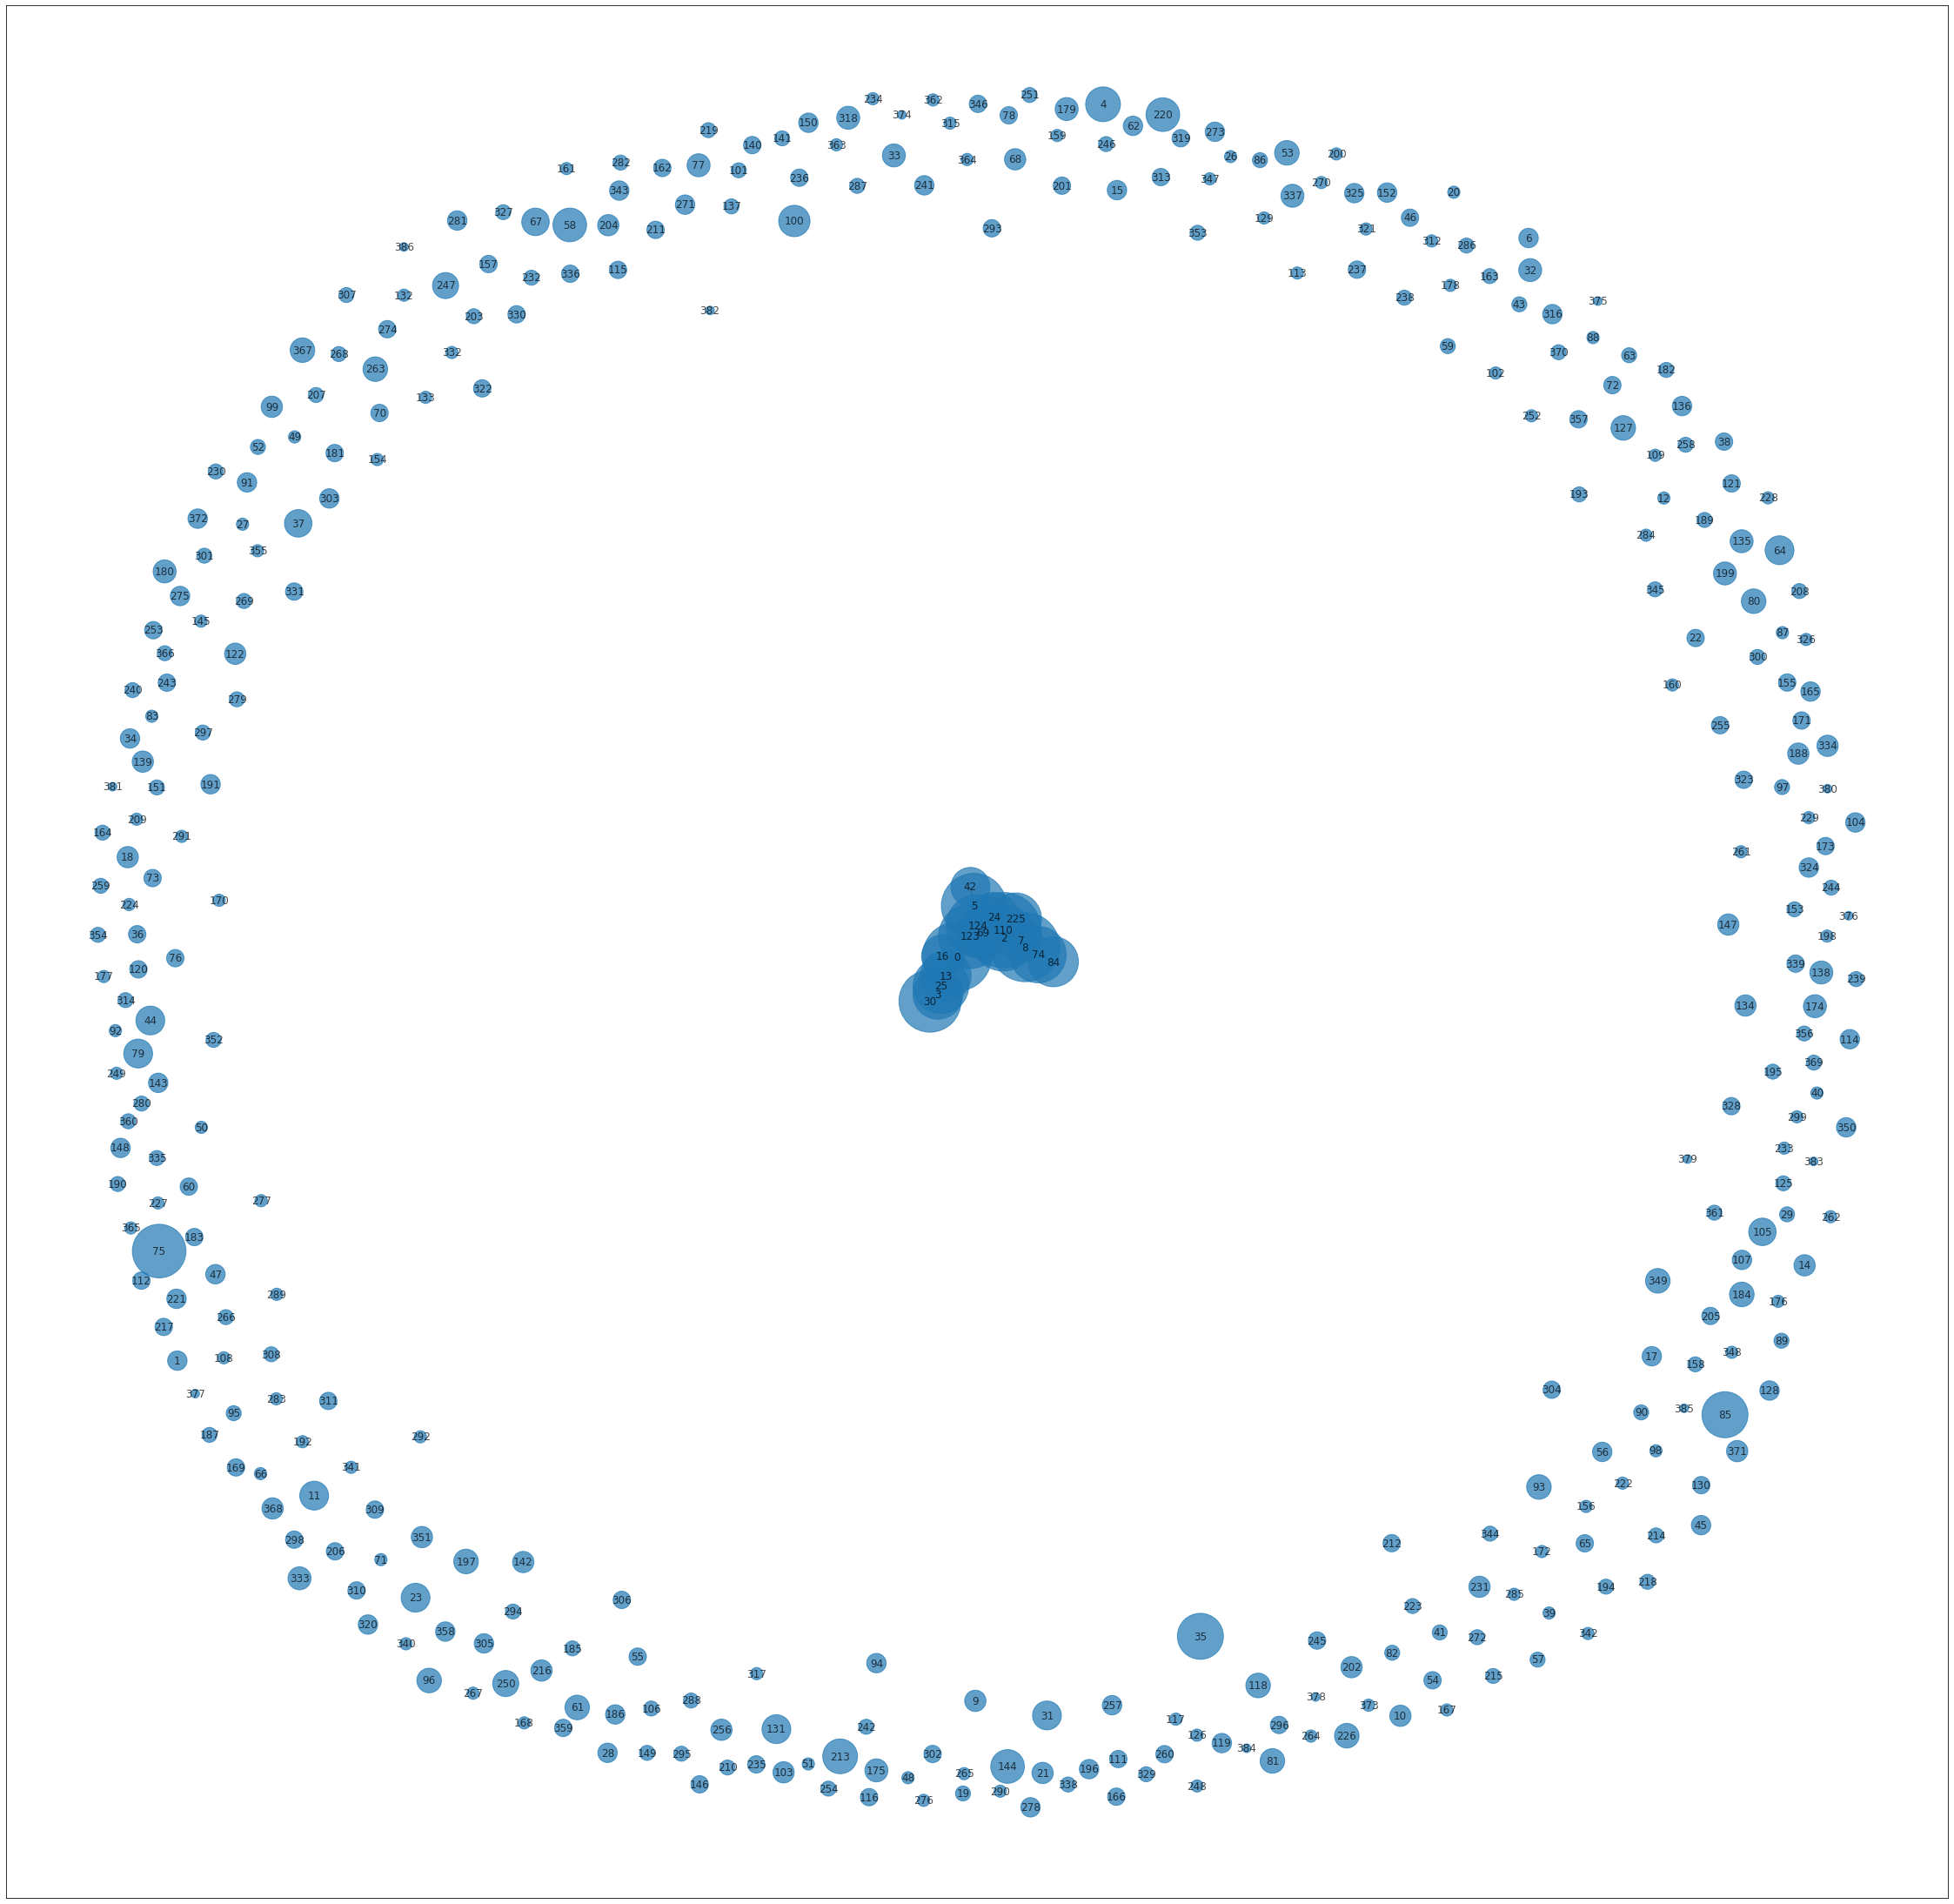

In [14]:
plt.figure(figsize =(40,40))
sp = nx.spring_layout(G_g)
node_size = [100 * len(total_groups[an.find_group(ID, total_groups)].authors) for ID in G_g] 
nx.draw_networkx(G_g,
                 pos=sp, 
                 with_labels=True, 
                 node_size=node_size, 
                 alpha=0.7,
                 cmap = plt.cm.Set3
                )
# plt.axes('off')
plt.savefig('../image/network_graph_research_group'+years+'.pdf', bbox_inches='tight')
plt.show()

### Top Research Groups

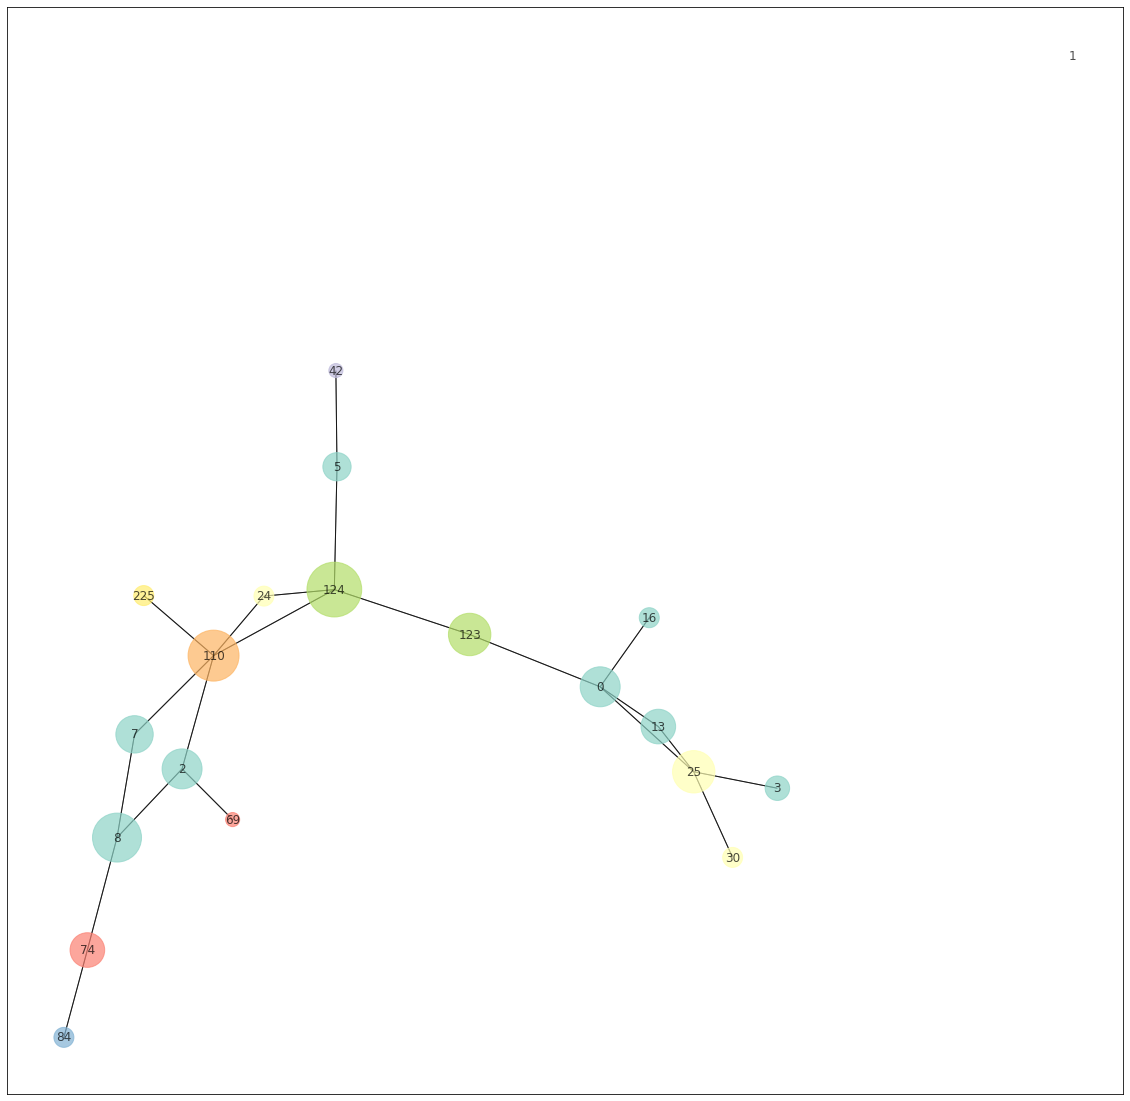

In [18]:
for group in total_groups:
    group.add_all_paper(author_list)

G_r, r_groups = an.get_top_group(G, total_groups, 20)

plt.figure(figsize =(20,20))
sp = nx.spring_layout(G_r)
node_size = [200 * nx.get_node_attributes(G_r, 'authors')[v] for v in G_r] 
nx.draw_networkx(G_r,
                 pos=sp, 
                 with_labels=True, 
                 node_size=node_size, 
                 node_color=G_r,
                 alpha=0.7,
                 cmap = plt.cm.Set3
                )
# plt.axes('off')
plt.savefig('../image/network_graph_top_research_groups'+years+'.pdf', bbox_inches='tight')
plt.show()

### Network Graph - Louvain algorithm

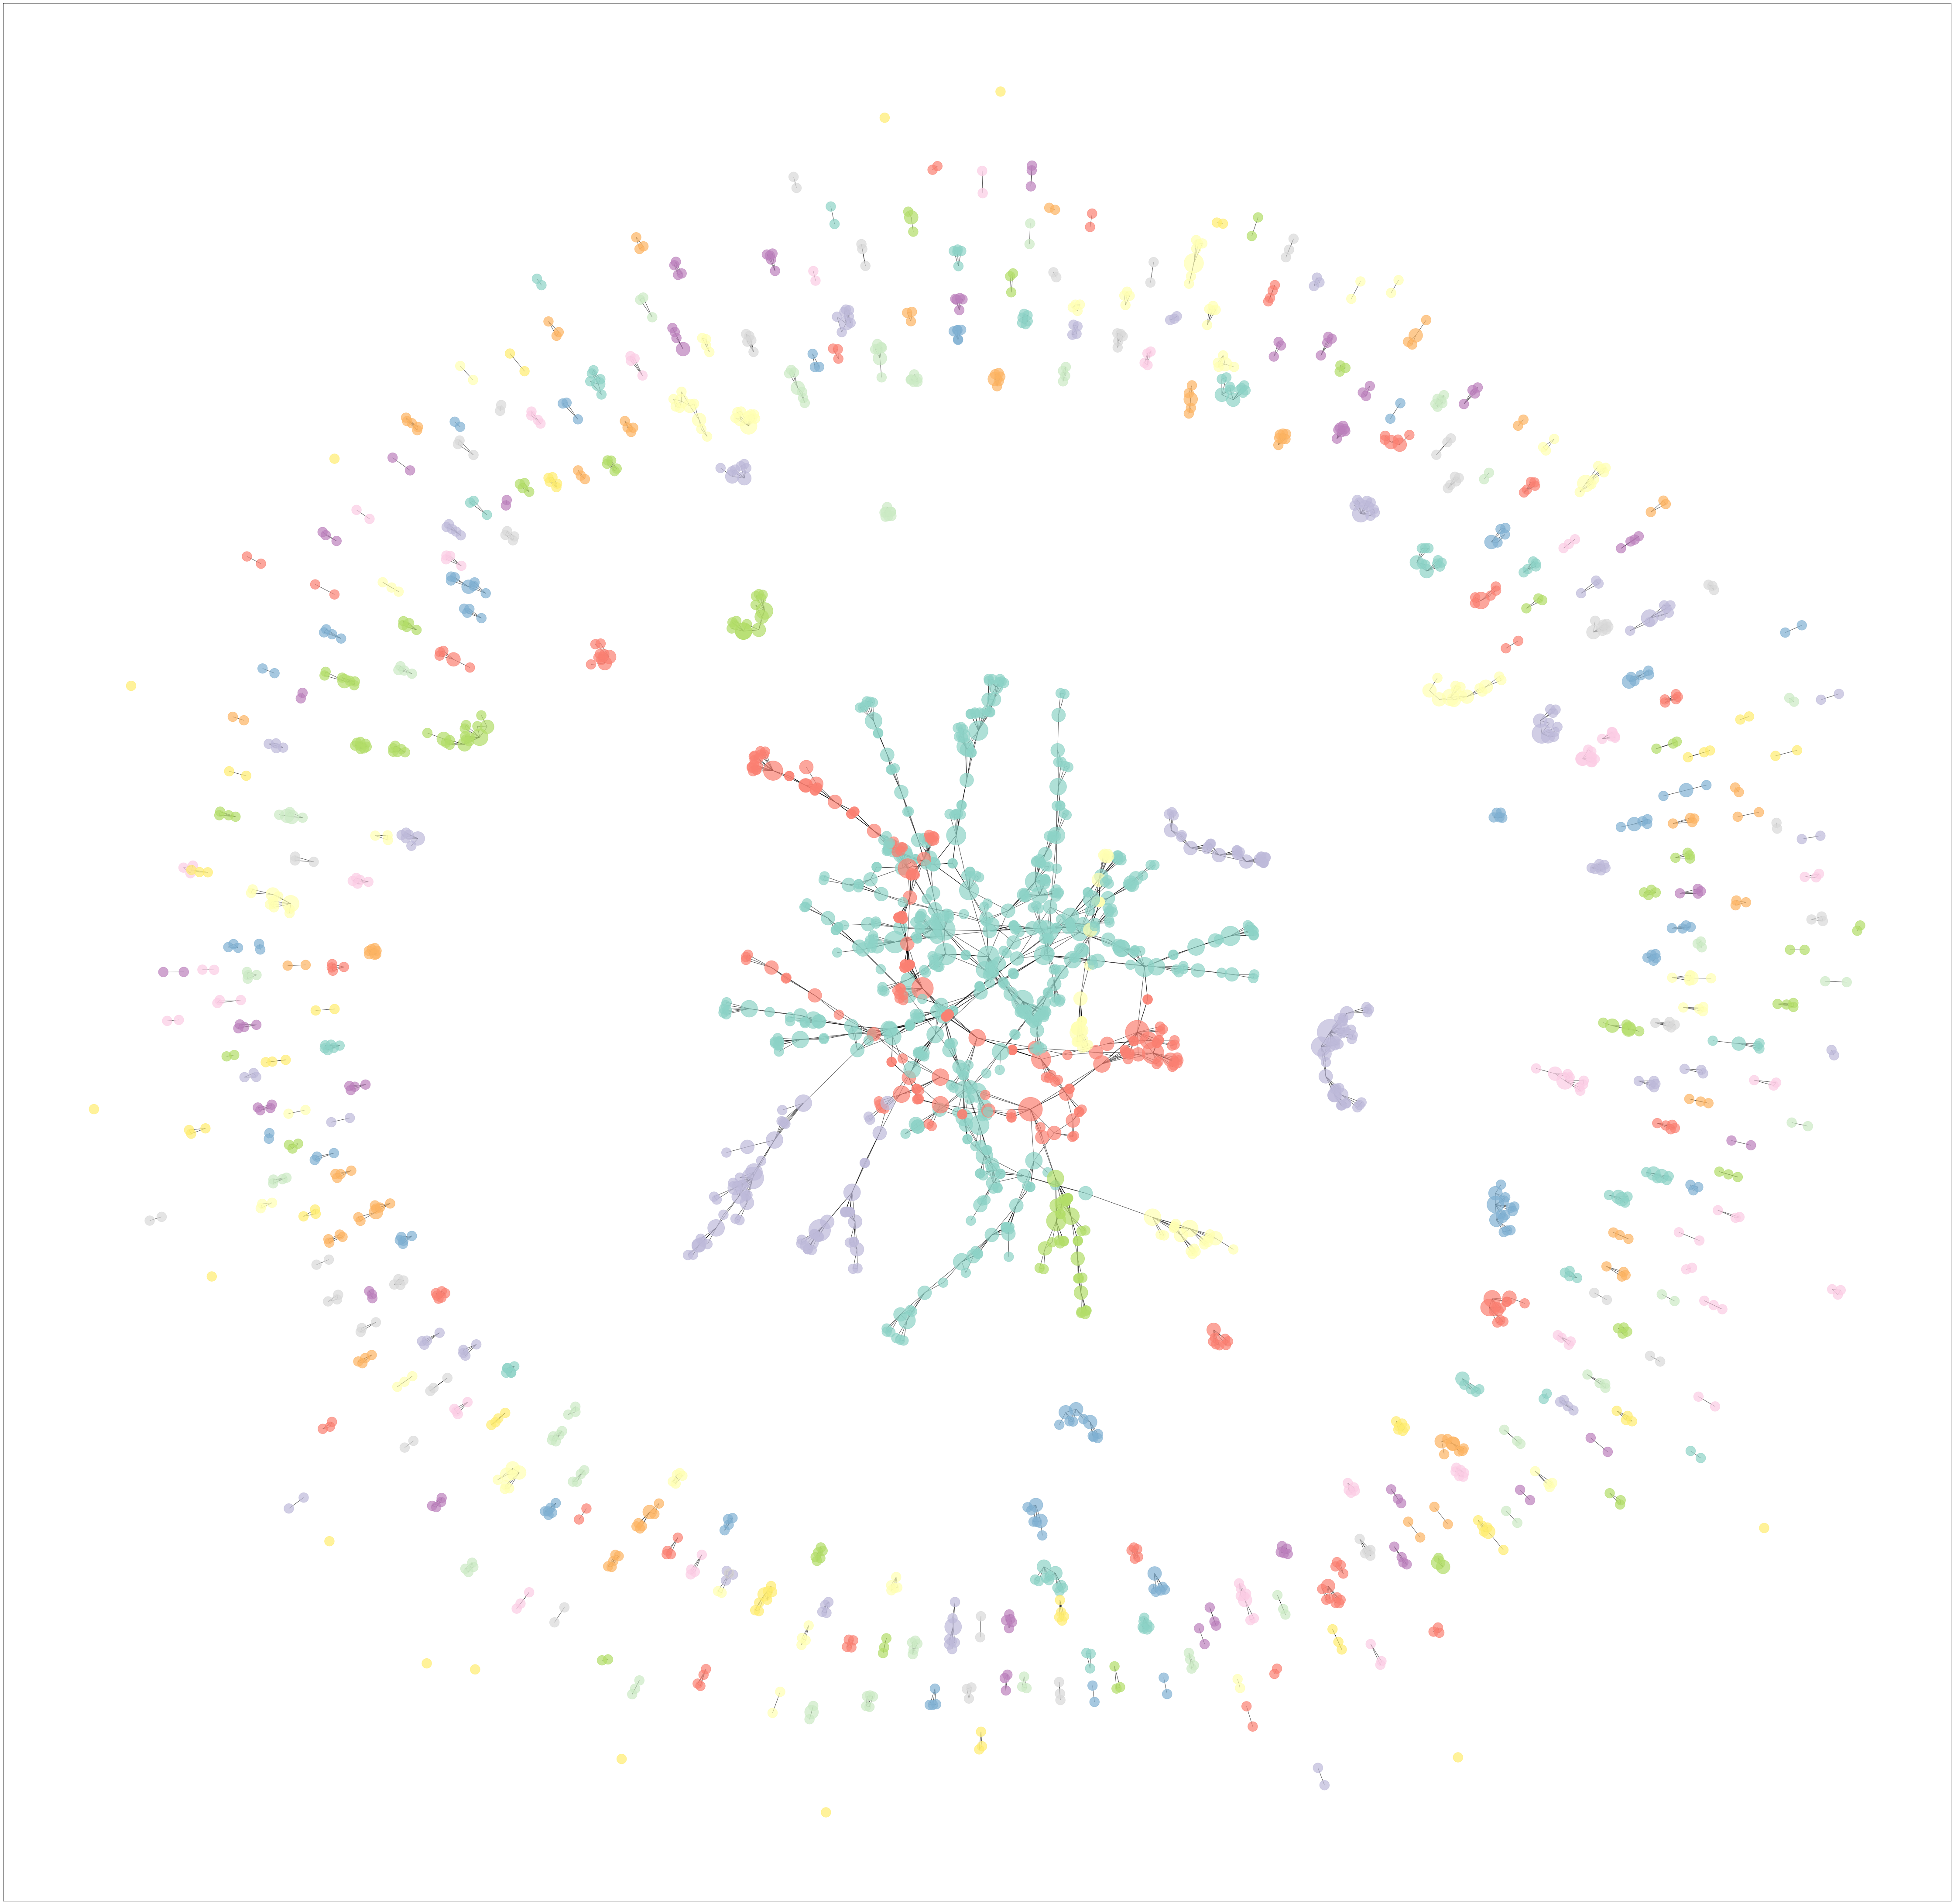

In [13]:
plt.figure(figsize =(80,80))
sp = nx.spring_layout(G)
node_size = [500 * nx.get_node_attributes(G, 'papers')[v] for v in G] 
nx.draw_networkx(G,
                 pos=sp, 
                 with_labels=False, 
                 node_size=node_size,
                 node_color=values, 
                 alpha=0.7,
                 cmap = plt.cm.Set3
                )
# plt.axes('off')
plt.savefig('../image/network_graph_Louvain1'+years+'.pdf', bbox_inches='tight')
plt.show()

#### Coloring top 10 authors with most papers

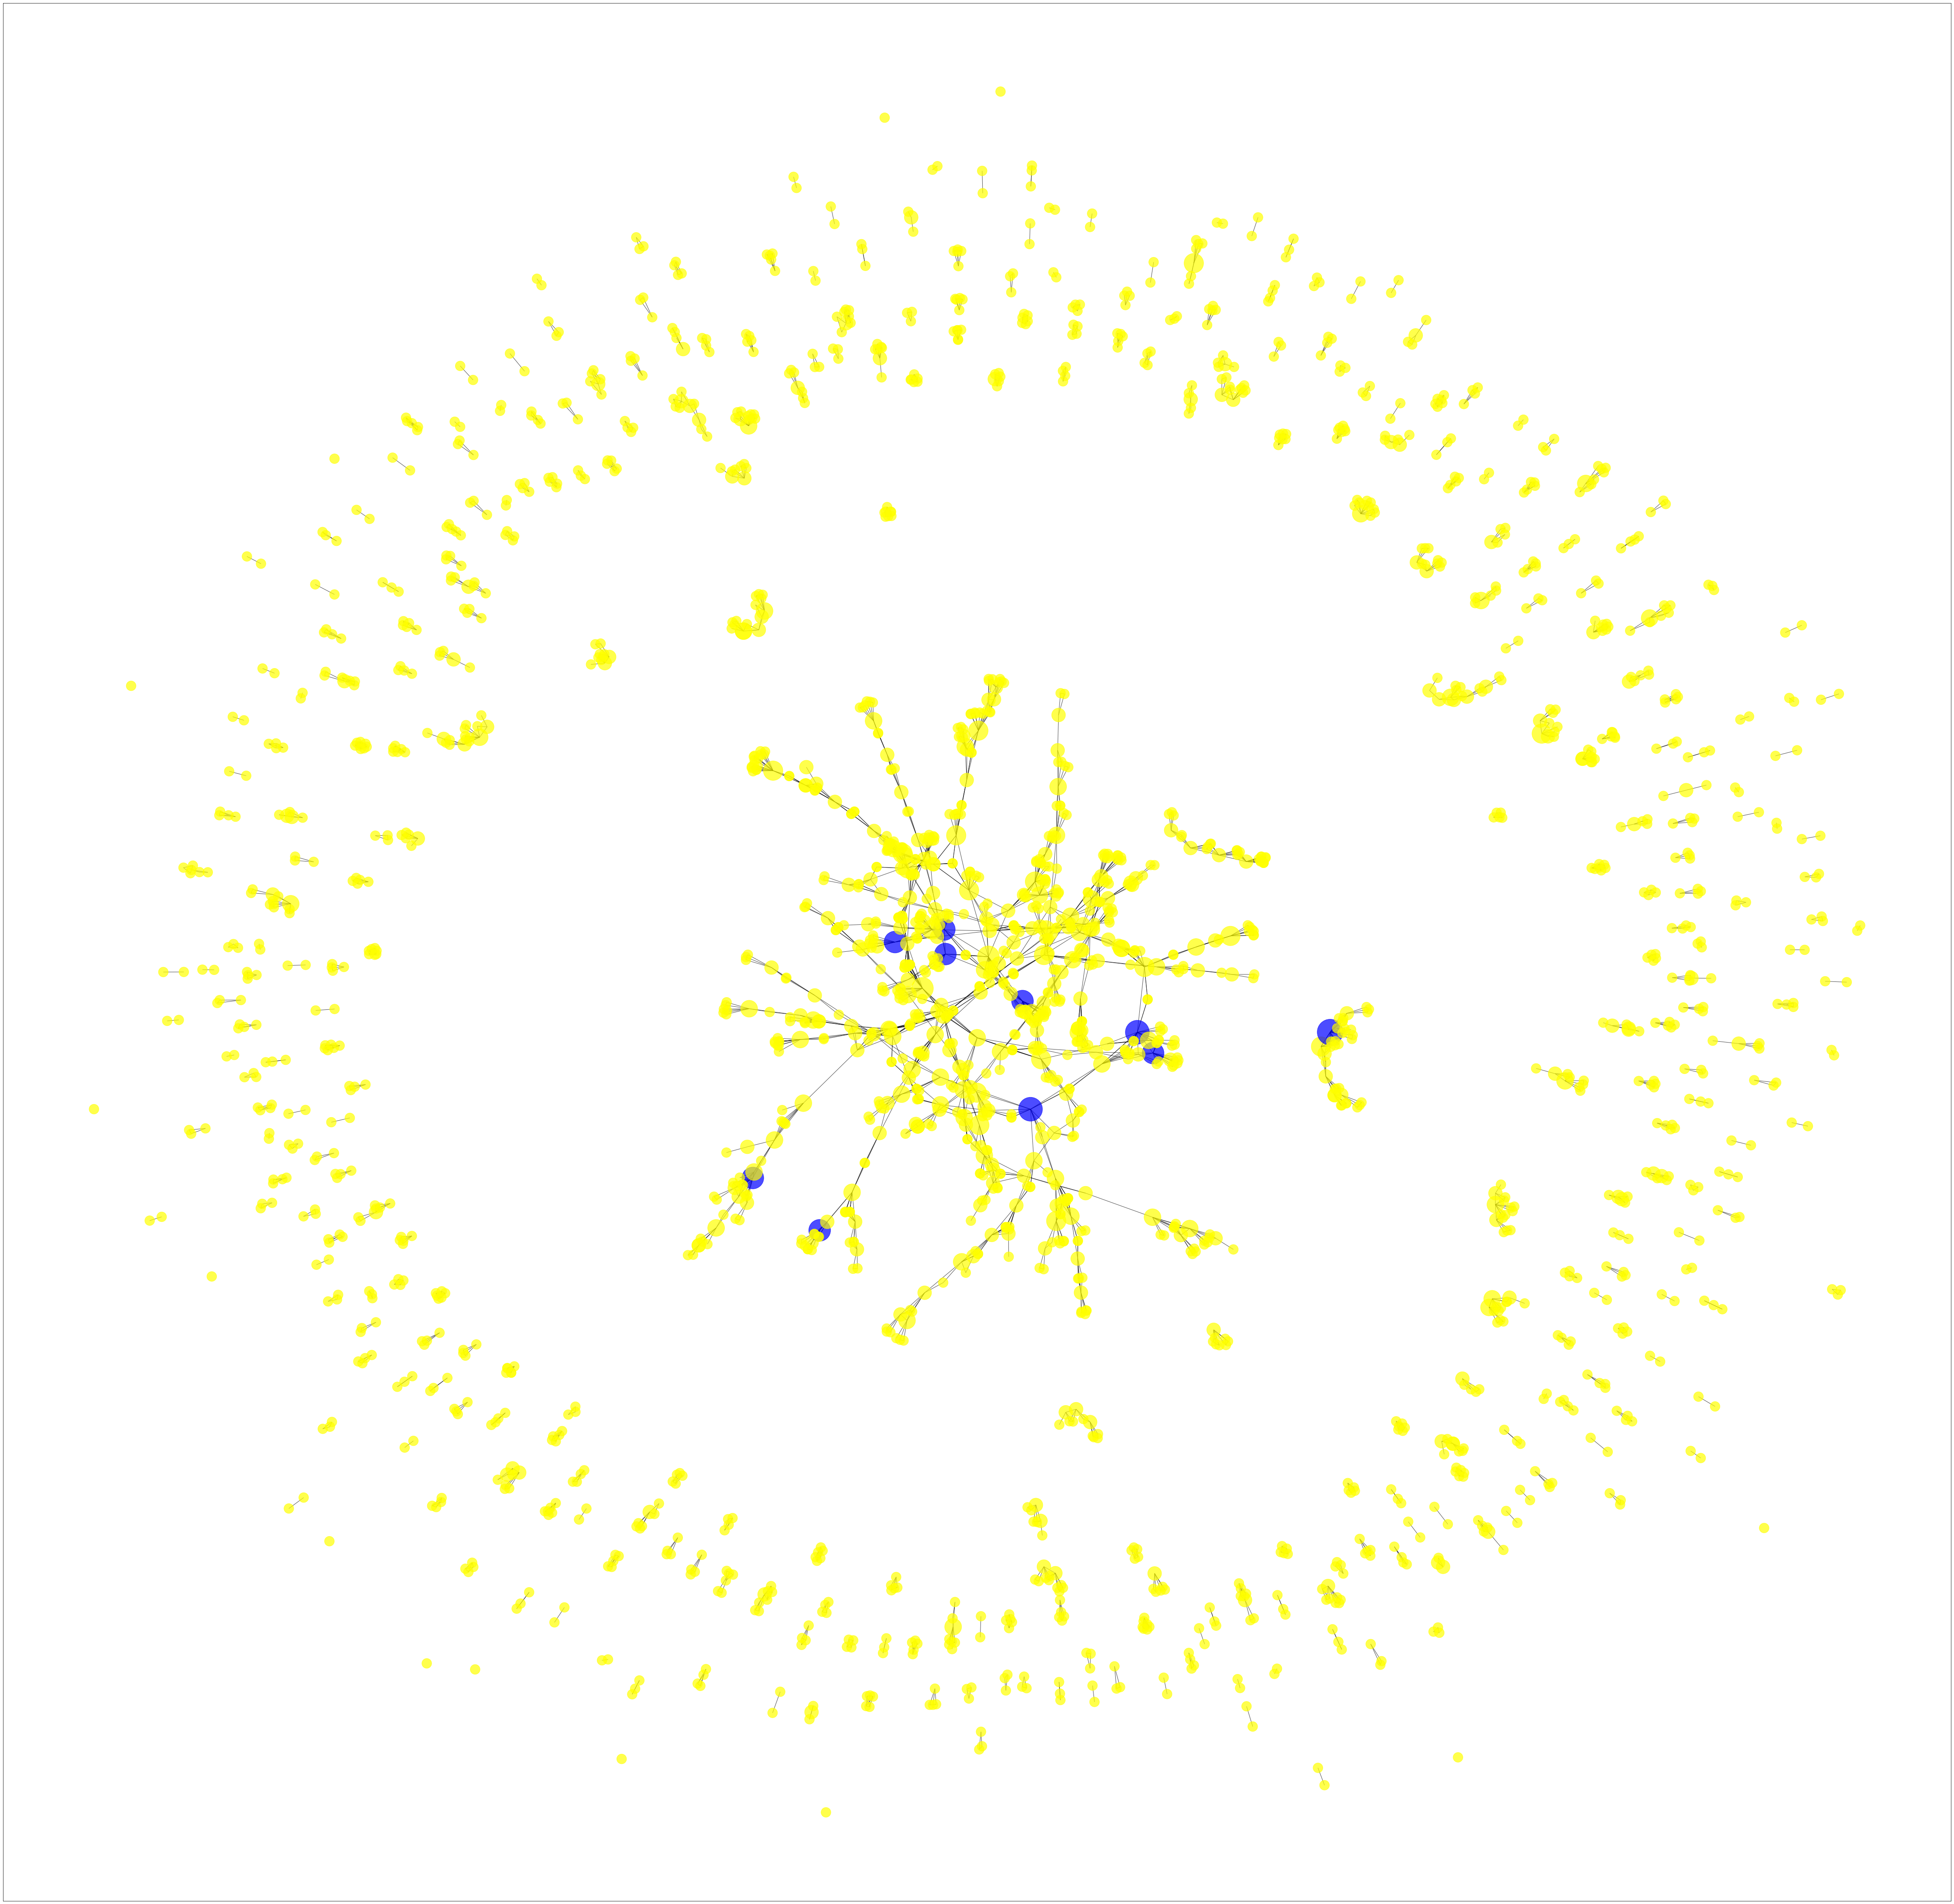

In [14]:
new_colormap = an.make_colormap(G, sorted_authors, author_list, 10)

plt.figure(figsize =(80,80))
node_size = [500 * nx.get_node_attributes(G, 'papers')[v] for v in G] 
nx.draw_networkx(G, 
                 pos=sp, 
                 with_labels=False, 
                 node_size=node_size,
                 node_color=new_colormap, 
                 alpha=0.7
                )
# plt.axes('off')
plt.savefig('../image/network_graph_top_paper'+years+'.pdf', bbox_inches='tight')
plt.show()

#### Coloring top 10 authors working with most research groups 

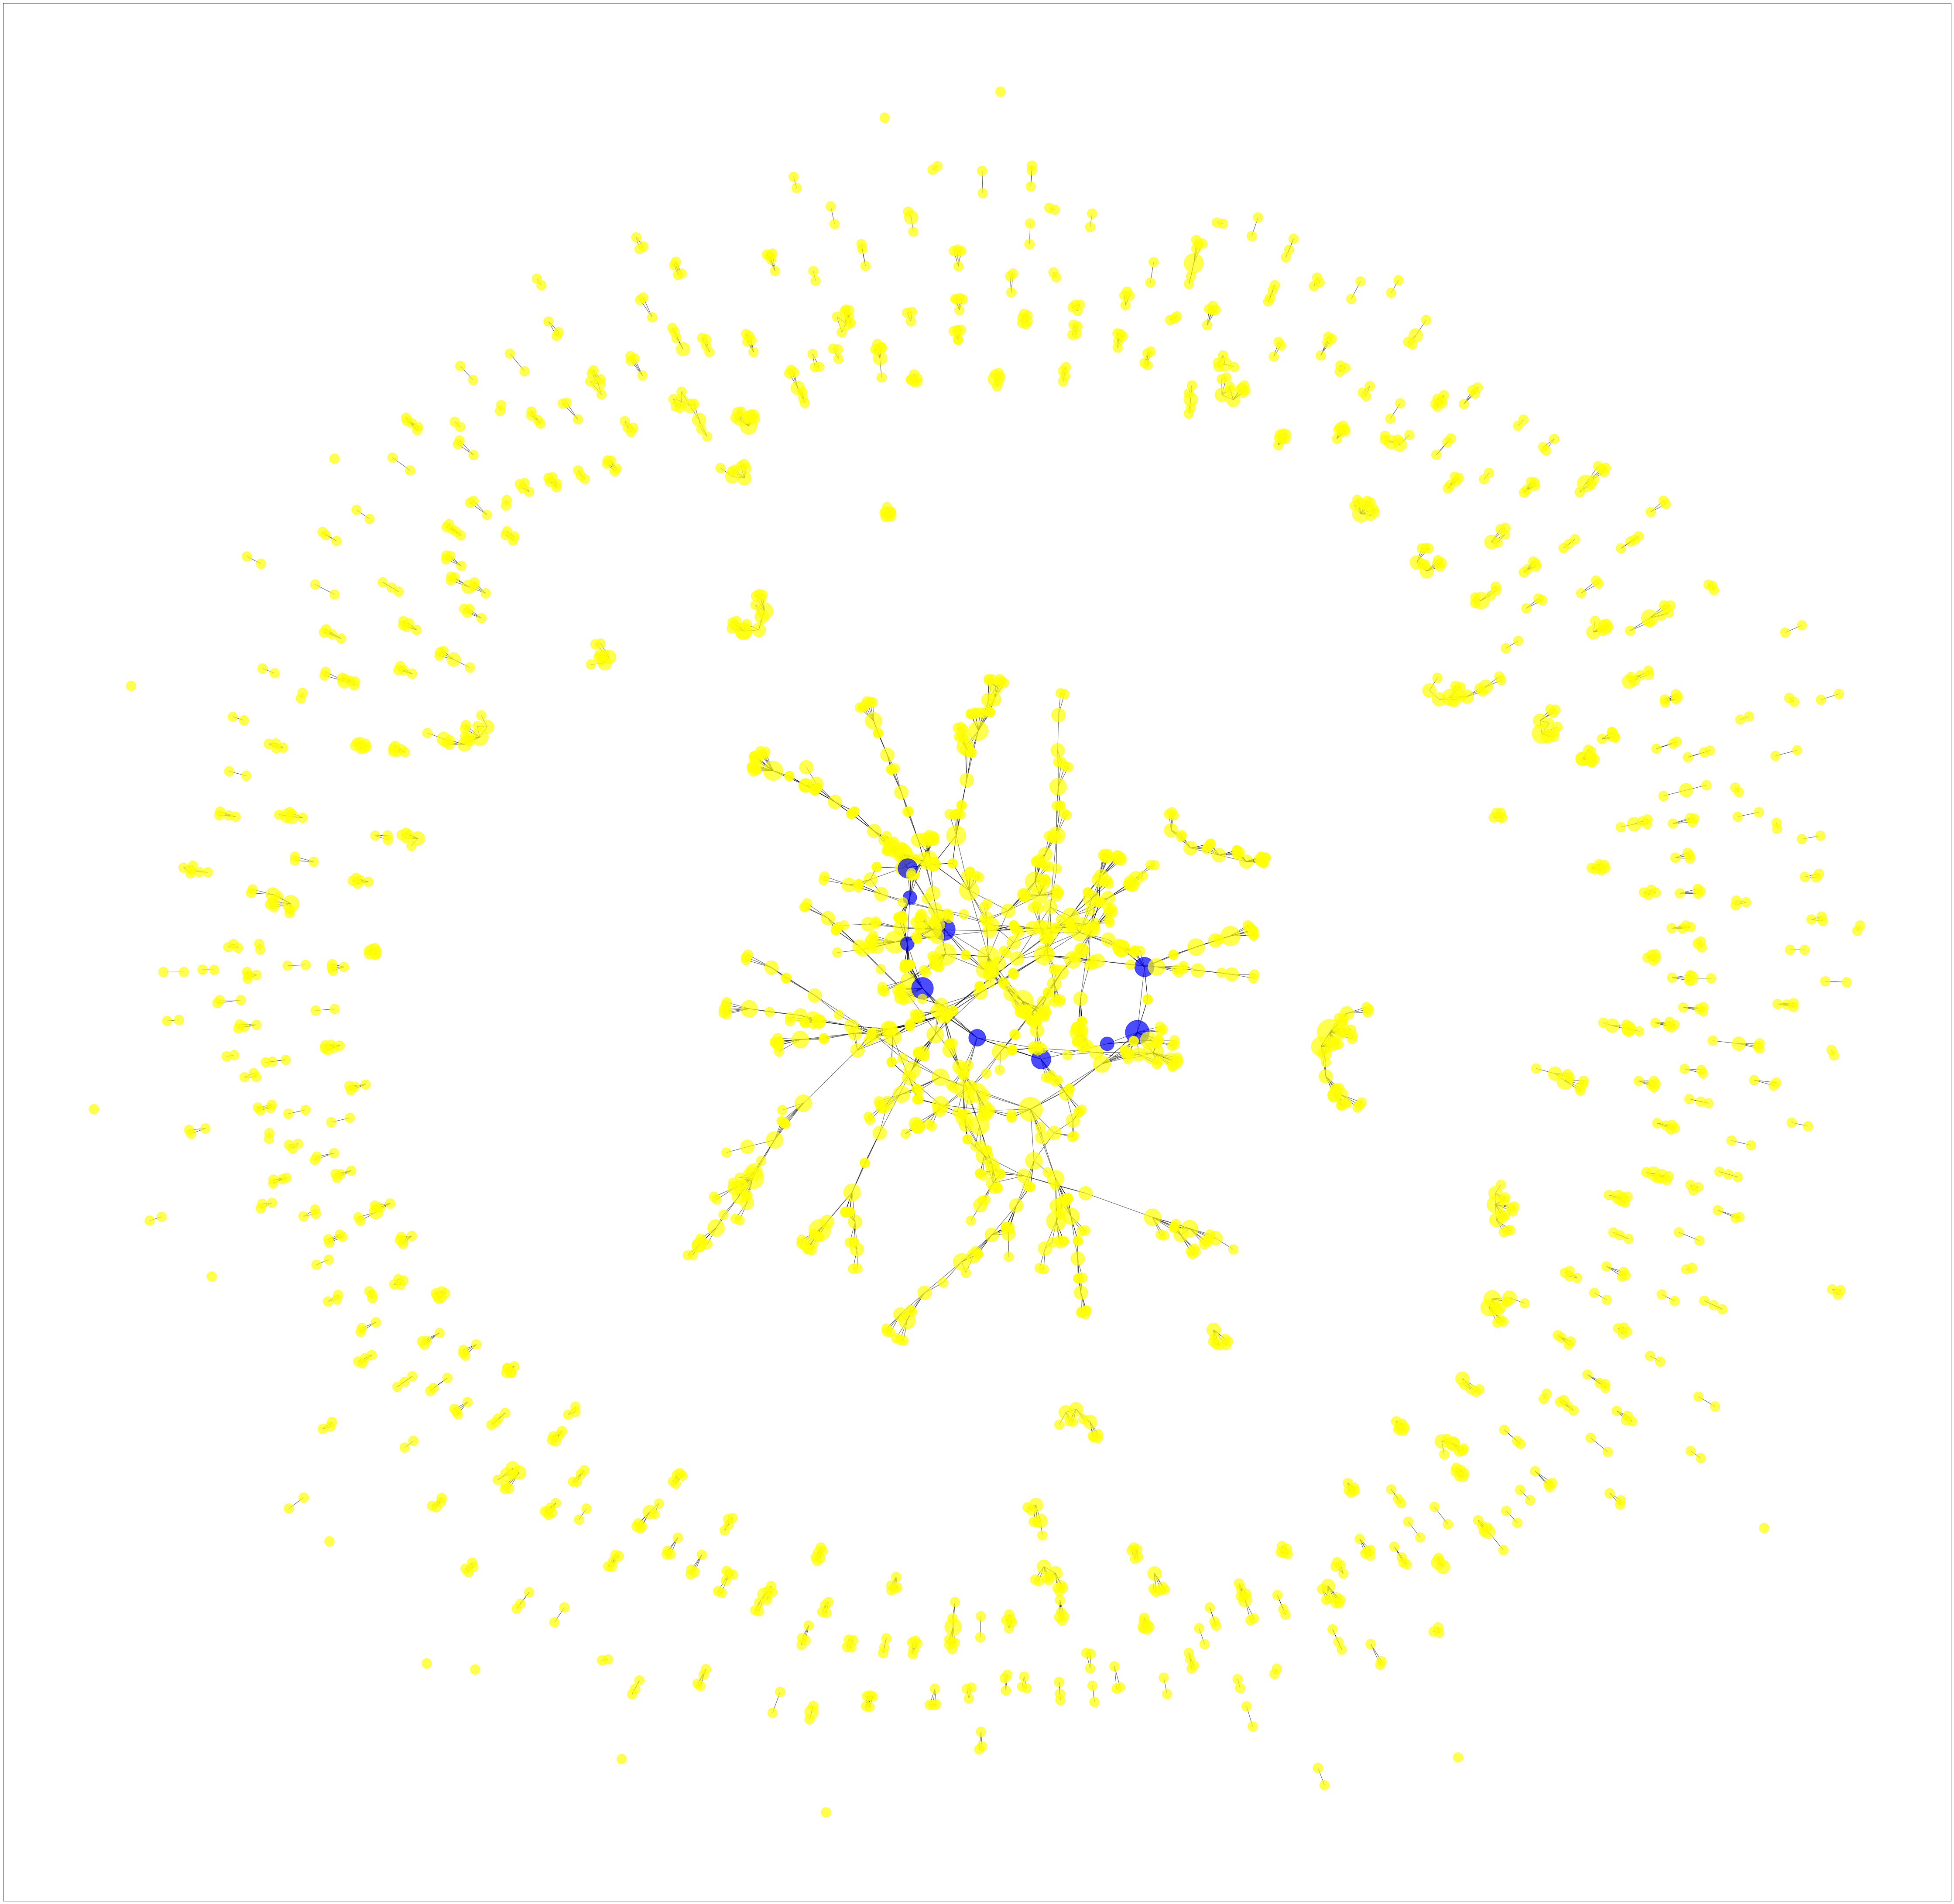

In [15]:
new_colormap = an.make_colormap(G, [x[0] for x in Cb], author_list, 10)

plt.figure(figsize =(80,80))
node_size = [500 * nx.get_node_attributes(G, 'papers')[v] for v in G] 
nx.draw_networkx(G, 
                 pos=sp, 
                 with_labels=False, 
                 node_size=node_size,
                 node_color=new_colormap, 
                 alpha=0.7
                )
# plt.axes('off')
plt.savefig('../image/network_graph_top_most_RG'+years+'.pdf', bbox_inches='tight')
plt.show()

#### Get top 5 research groups(Louvain algorithm)

322
Gabriele Abbati Philippe Wenk
Gabriele Abbati Michael A. Osborne
Andreas Krause Gabriele Abbati
Bernhard Schölkopf Gabriele Abbati
Gabriele Abbati Stefan Bauer
Michael A. Osborne Philippe Wenk
Andreas Krause Philippe Wenk
Bernhard Schölkopf Philippe Wenk
Philippe Wenk Stefan Bauer
Andreas Krause Michael A. Osborne
Bernhard Schölkopf Michael A. Osborne
Michael A. Osborne Stefan Bauer
Andreas Krause Bernhard Schölkopf
Andreas Krause Stefan Bauer
Bernhard Schölkopf Stefan Bauer
Bryan Perozzi Sami Abu-El-Haija
Amol Kapoor Sami Abu-El-Haija
Nazanin Alipourfard Sami Abu-El-Haija
Kristina Lerman Sami Abu-El-Haija
Hrayr Harutyunyan Sami Abu-El-Haija
Greg Ver Steeg Sami Abu-El-Haija
Aram Galstyan Sami Abu-El-Haija
Amol Kapoor Bryan Perozzi
Bryan Perozzi Nazanin Alipourfard
Bryan Perozzi Kristina Lerman
Bryan Perozzi Hrayr Harutyunyan
Bryan Perozzi Greg Ver Steeg
Aram Galstyan Bryan Perozzi
Amol Kapoor Nazanin Alipourfard
Amol Kapoor Kristina Lerman
Amol Kapoor Hrayr Harutyunyan
Amol Kapoor 

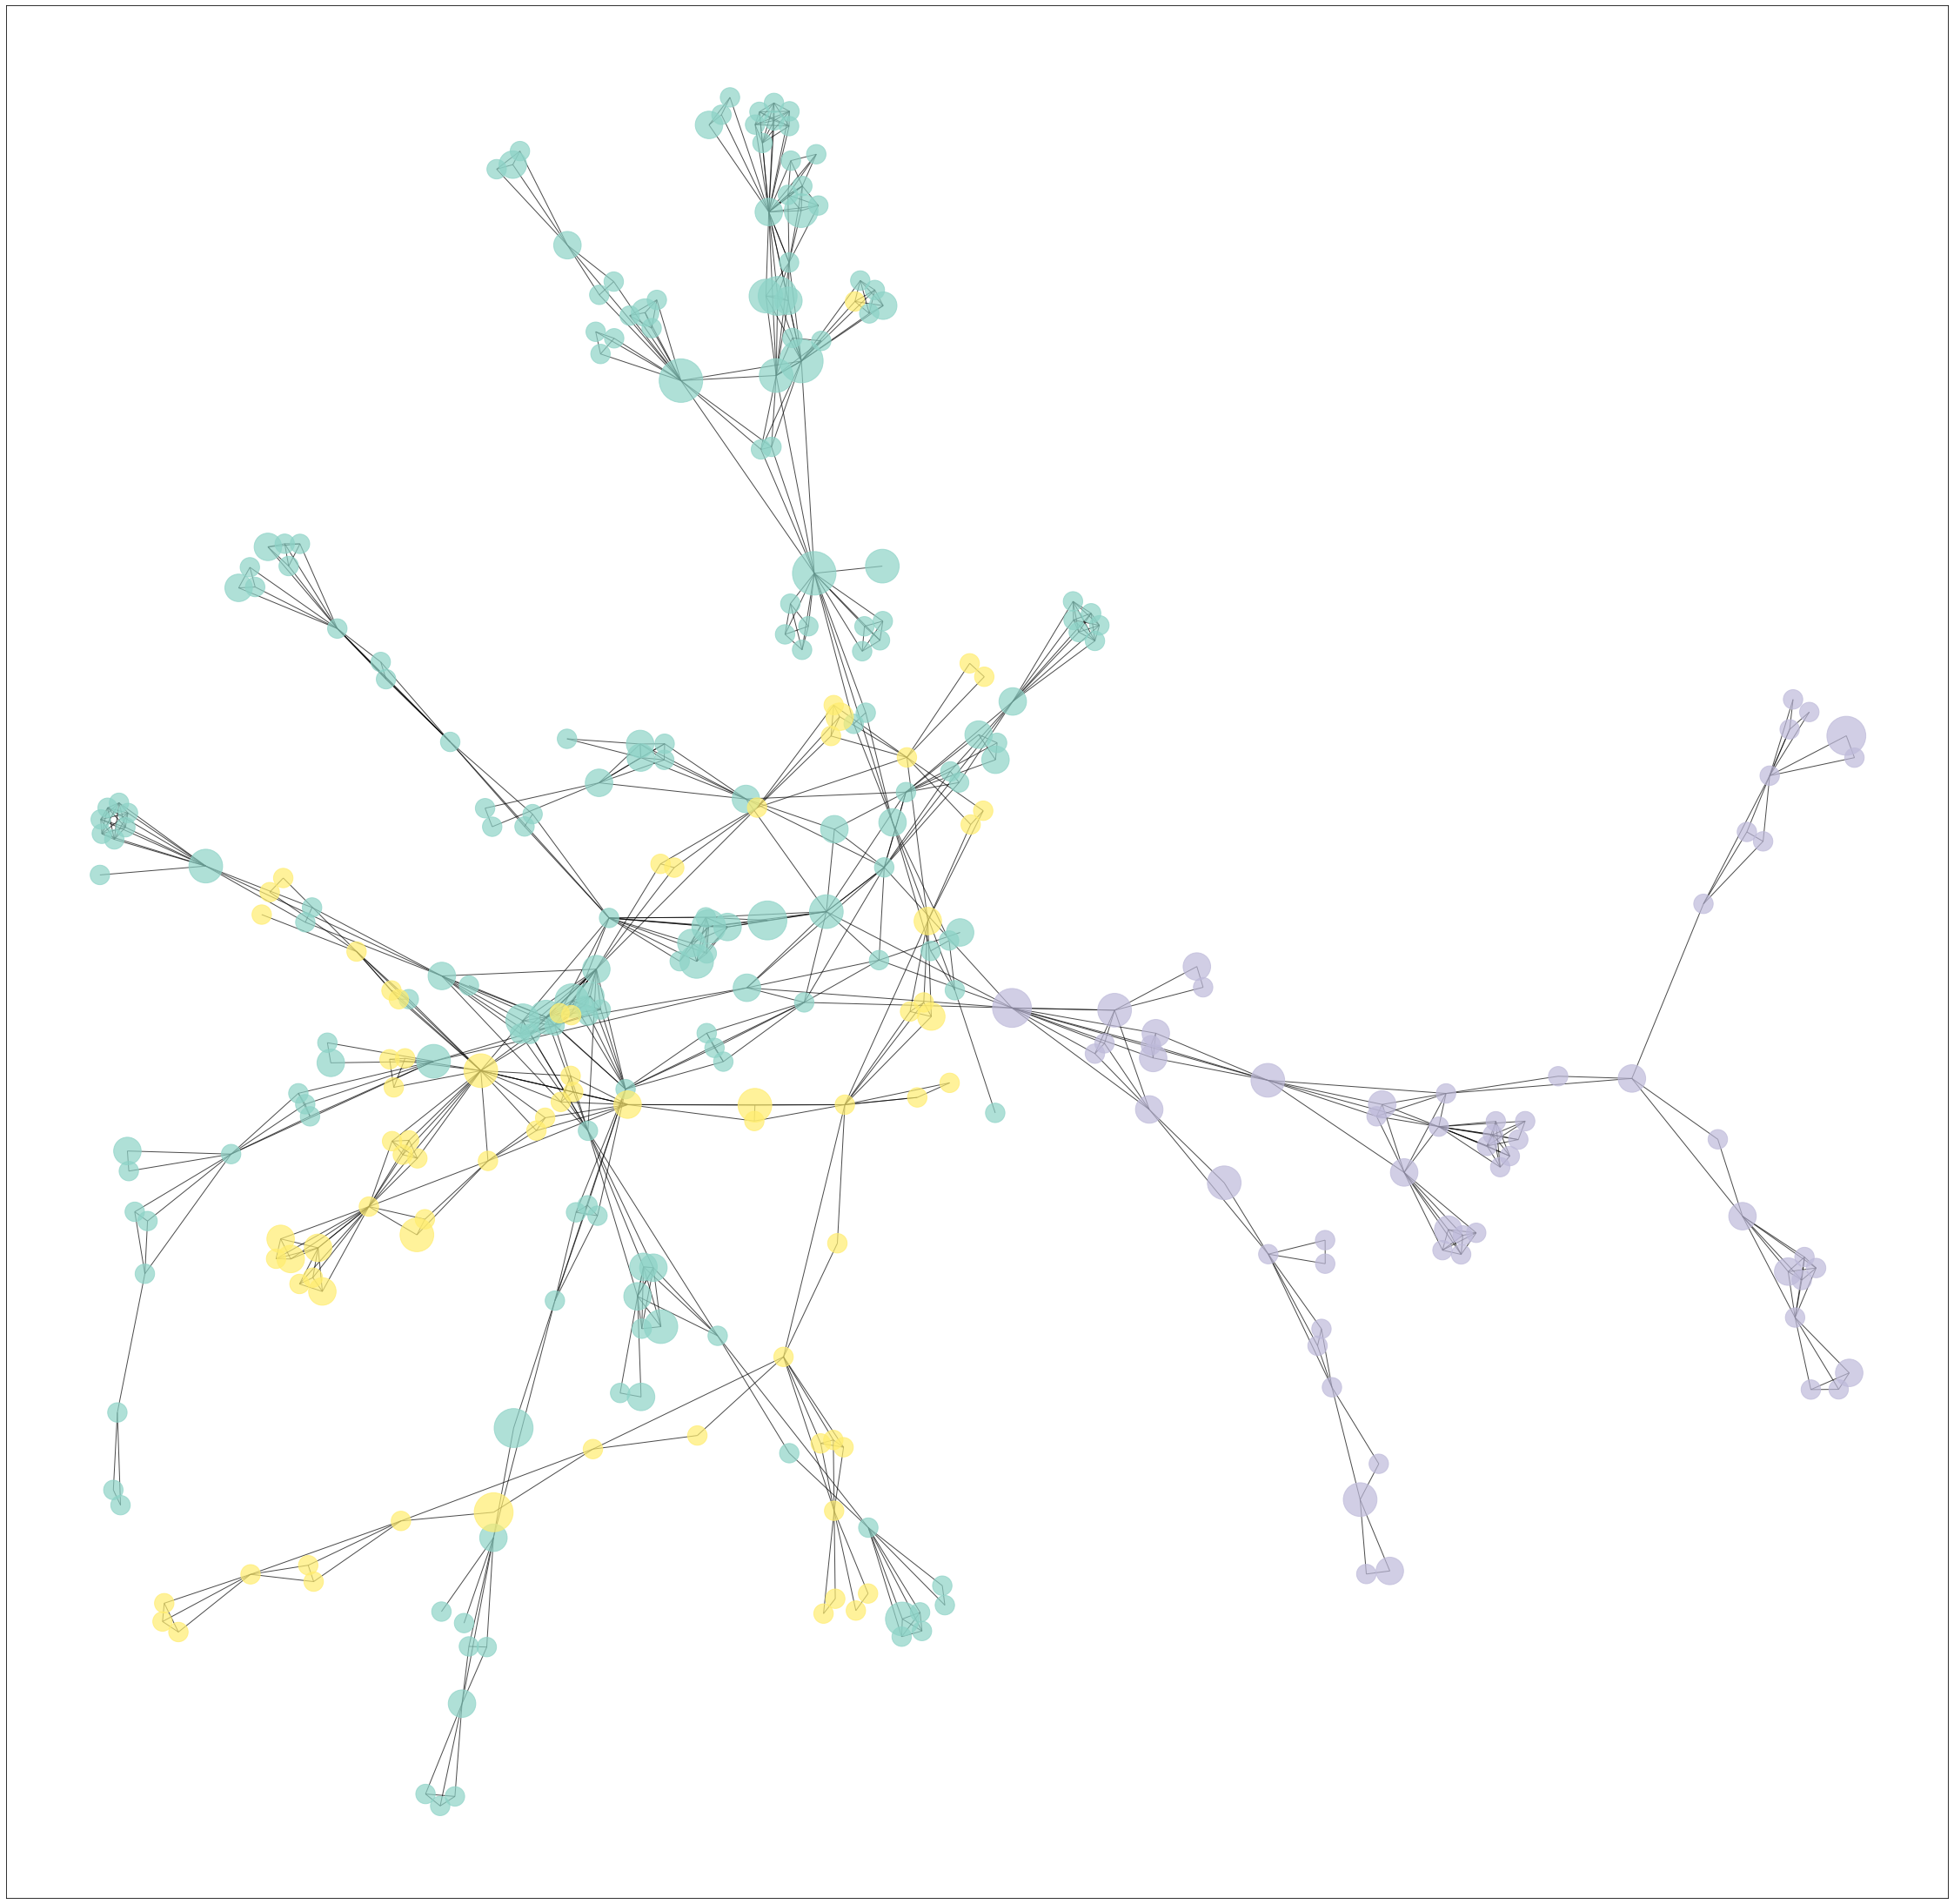

In [16]:
G_r, r_values = an.get_group_edges(G, values, counts, author_list, paper_list, 5)

plt.figure(figsize =(40,40))
sp = nx.spring_layout(G_r)
node_size = [500 * nx.get_node_attributes(G_r, 'papers')[v] for v in G_r] 
nx.draw_networkx(G_r,
                 pos=sp, 
                 with_labels=False, 
                 node_size=node_size,
                 node_color=r_values, 
                 alpha=0.7,
                 cmap = plt.cm.Set3
                )
# plt.axes('off')
plt.savefig('../image/network_graph_top_RG_Louvain'+years+'.pdf', bbox_inches='tight')
plt.show()

In [19]:
make_research_groups(G, values)

Gabriele Abbati 0
Philippe Wenk 0
Michael A. Osborne 0
Andreas Krause 0
Bernhard Schölkopf 0
Stefan Bauer 0
Axel Abels 1
Diederik Roijers 1
Tom Lenaerts 1
Ann Nowé 1
Denis Steckelmacher 1
Bryan Perozzi 2
Sami Abu-El-Haija 2
Amol Kapoor 2
Nazanin Alipourfard 2
Kristina Lerman 2
Hrayr Harutyunyan 2
Greg Ver Steeg 2
Aram Galstyan 2
Clement Canonne 3
Jayadev Acharya 3
Himanshu Tyagi 3
Chris De Sa 2
Dylan Foster 2
Karthik Sridharan 2
Ziteng Sun 2
Roy Adams 4
Yuelong Ji 4
Xiaobin Wang 4
Suchi Saria 4
Adrian Weller 5
Tameem Adel 5
Abhijin Adiga 6
Chris J Kuhlman 6
Madhav Marathe 6
S Ravi 6
Anil Vullikanti 6
Brian Bullins 7
Naman Agarwal 7
Xinyi Chen 7
Elad Hazan 7
Karan Singh 7
Cyril Zhang 7
Yi Zhang 7
Ashish Agarwal 7
Sham Kakade 7
Alekh Agarwal 7
Miroslav Dudik 7
Zhiwei Steven Wu 7
Chen Liang 5
Rishabh Agarwal 5
Dale Schuurmans 5
Mohammad Norouzi 5
Brian Trippe 5
Raj Agrawal 5
Jonathan Huggins 5
Tamara Broderick 5
Nicolas Le Roux 5
Zafarali Ahmed 5
Hiromi Arai 8
Ulrich Aivodji 8
Olivier For

Enrique Munoz De Cote 146
Alexander Greaves-Tunnell 147
Zaid Harchaoui 147
David Greenberg 148
Marcel Nonnenmacher 148
Jakob Macke 148
Daniel Greenfeld 149
Meirav Galun 149
Ronen Basri 149
Irad Yavneh 149
Ron Kimmel 149
Klaus Greff 123
Raphaël Lopez Kaufman 123
Rishabh Kabra 123
Nick Watters 123
Christopher Burgess 123
Daniel Zoran 123
Loic Matthey 123
Alexander Lerchner 123
Aaron Zweig 83
Guosheng Yin 150
Jiaqi Gu 150
Chaoyu Guan 23
Xiting Wang 23
Quanshi Zhang 23
Runjin Chen 23
Xing Xie 23
Arthur Guez 123
Mehdi Mirza 123
Karol Gregor 123
Sebastien Racaniere 123
Theophane Weber 123
David Raposo 123
Adam Santoro 123
Laurent Orseau 123
Tom Eccles 123
Greg Wayne 123
David Silver 123
Timothy Lillicrap 123
Genevieve Patterson 151
Limor Gultchin 151
Nancy Baym 151
Nathaniel Swinger 151
Adam Kalai 151
Chuan Guo 3
Jacob Gardner 3
Yurong You 3
Andrew Gordon Wilson 3
Kilian Weinberger 3
Tao Lin 152
Tian Guo 152
Nino Antulov-Fantulin 152
Lingbing Guo 23
Zequn Sun 23
Albert Gural 153
Boris Murman

Ichiro Takeuchi 109
Thomas Nedelec 37
Vianney Perchet 37
Duc Tam Nguyen 259
Zhongyu Lou 259
Michael Klar 259
Thomas Brox 259
Than Huy Nguyen 64
Gael Richard 64
Nils Bertschinger 69
Rajbir Nirwan 69
Robert Williamson 69
Arild Nøkland 260
Lars Hiller Eidnes 260
Guido Novati 261
Petros Koumoutsakos 261
Luke Hewitt 15
Maxwell Nye 15
Armando Solar-Lezama 15
Eli Bingham 262
Fritz Obermeyer 262
Martin Jankowiak 262
Neeraj Pradhan 262
Justin Chiu 262
Alexander Rush 262
Noah Goodman 262
David Sontag 263
Michael Oberst 263
Peter Ochs 143
Yura Malitsky 143
Augustus Odena 143
Catherine Olsson 143
David Andersen 143
Ian Goodfellow 143
Thomas Gärtner 0
Kenta Oono 264
Taiji Suzuki 264
Miruna Oprescu 7
Vasilis Syrgkanis 7
Dave Zachariah 265
Muhammad Osama 265
Thomas B. Schön 265
Mahdi Soltanolkotabi 266
Samet Oymak 266
Georgios Piliouras 267
Ioannis Panageas 267
Xiao Wang 267
Kun Xu 224
Tianyu Pang 224
Chao Du 224
Ning Chen 224
Konstantinos Panousis 268
Sotirios Chatzis 268
Sergios Theodoridis 268
Mat

Zhiru Zhang 3
Rui Zhao 368
Xudong Sun 368
Volker Tresp 368
Baojian Zhou 369
Feng Chen 369
Yiming Ying 369
Dongruo Zhou 332
Jiadong Liang 83
Zhiming Zhou 83
Yuxuan Song 83
Hongwei Wang 83
Yong Yu 83
Zhihua Zhang 83
Mo Zhou 224
Tianyi Liu 224
Yan Li 224
Dachao Lin 224
Enlu Zhou 224
Hongpeng Zhou 366
Minghao Yang 366
Wei Pan 366
Chen Zhu 370
W. Ronny Huang 370
Hengduo Li 370
Gavin Taylor 370
Christoph Studer 370
Tom Goldstein 370
Chunjiang Zhu 371
Sabine Storandt 371
Kam-Yiu Lam 371
Song Han 371
Jinbo Bi 371
Yu-Xiang Wang 372
Yuqing Zhu 372
Hanxiao Wang 164
Pengkai Zhu 164
Jingfeng Wu 367
Bing Yu 367
Lei Wu 367
Jinwen Ma 367
Zhenxun Zhuang 42
Francesco Orabona 42
Zachary Ziegler 262
Haipeng Luo 7
Julian Zimmert 7
Kyriacos Shiarli 122
Luisa Zintgraf 122
Vitaly Kurin 122
Katja Hofmann 122
Tijana Zrnic 121
George Chen 373
Ashok Cutkosky 374
Ehsan Elhamifar 375
Ilya Feige 376
Hiroshi Kajino 377
Nathan Kallus 378
Sylvain Lamprier 379
Quynh Nguyen 380
Vardan Papyan 381
Sujith Ravi 382
Matthew S

### Network Graph - node2vec and k-means algorithm

In [13]:
node2vec = Node2Vec(graph=G, # target graph
                    dimensions=50, # embedding dimension
                    walk_length=10, # number of nodes in each walks 
                    p = 1, # return hyper parameter
                    q = 0.0001, # inout parameter, q값을 작게 하면 structural equivalence를 강조하는 형태로 학습됩니다. 
                    weight_key=None, # if weight_key in attrdict 
                    num_walks=2000, 
                    workers=1,
                   )

for i, each_walk in enumerate(node2vec.walks):
    print(f"{i:0>2d}, {each_walk}")
    if i>1:
        break

Generating walks (CPU: 1): 100%|██████████| 2000/2000 [2:31:02<00:00,  4.53s/it]      


00, ['Jacob Gardner', 'Andrew Gordon Wilson', 'Christopher Fifty', 'Amauri Souza', 'Polina Kirichenko', 'Himanshu Tyagi', 'Yuwei Hu', 'Himanshu Tyagi', 'Tri Dao', 'Matthew Eichhorn']
01, ['Arthur Mensch', 'Vlad Niculae', 'Arthur Mensch', 'Michael Carbin', 'Charith Mendis', 'Alex Renda', 'Michael Carbin', 'Arthur Mensch', 'Andre Martins', 'Vlad Niculae']
02, ['Yi-An Ma', 'Samuel K. Ainsworth', 'Emily B. Fox', 'Ahmed M. Alaa', 'Emily B. Fox', 'Gerhard Neumann', 'Riad Akrour', 'Gerhard Neumann', 'Mihaela Schaar', 'Gerhard Neumann']


In [14]:
# 발생한 walk를 사용해서 학습을 시켜봅니다. 
# 여기서 fitting할때 사용하는 argument는 gensim의 word2vec과 같습니다. 
# 단 학습시킨 것을 model1처럼 어디에 집어넣어줘야 하는 것 같네요. 여기서 p나 q값을 조절하기는 어려운 것 같습니다. 
model1 = node2vec.fit(window=2)

In [15]:
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

In [16]:
model1 = node2vec.fit(window=10)
# kmeans clustering을 진행해줍니다. 

In [17]:
K = 5
kmeans = KMeans(n_clusters=K, random_state=0).fit(model1.wv.vectors)
# node의 cluster 부분을 attrdict에 업데이트해줍니다. 
for n, label in zip(model1.wv.index2entity, kmeans.labels_):
    G.nodes[n]['label'] = label
    

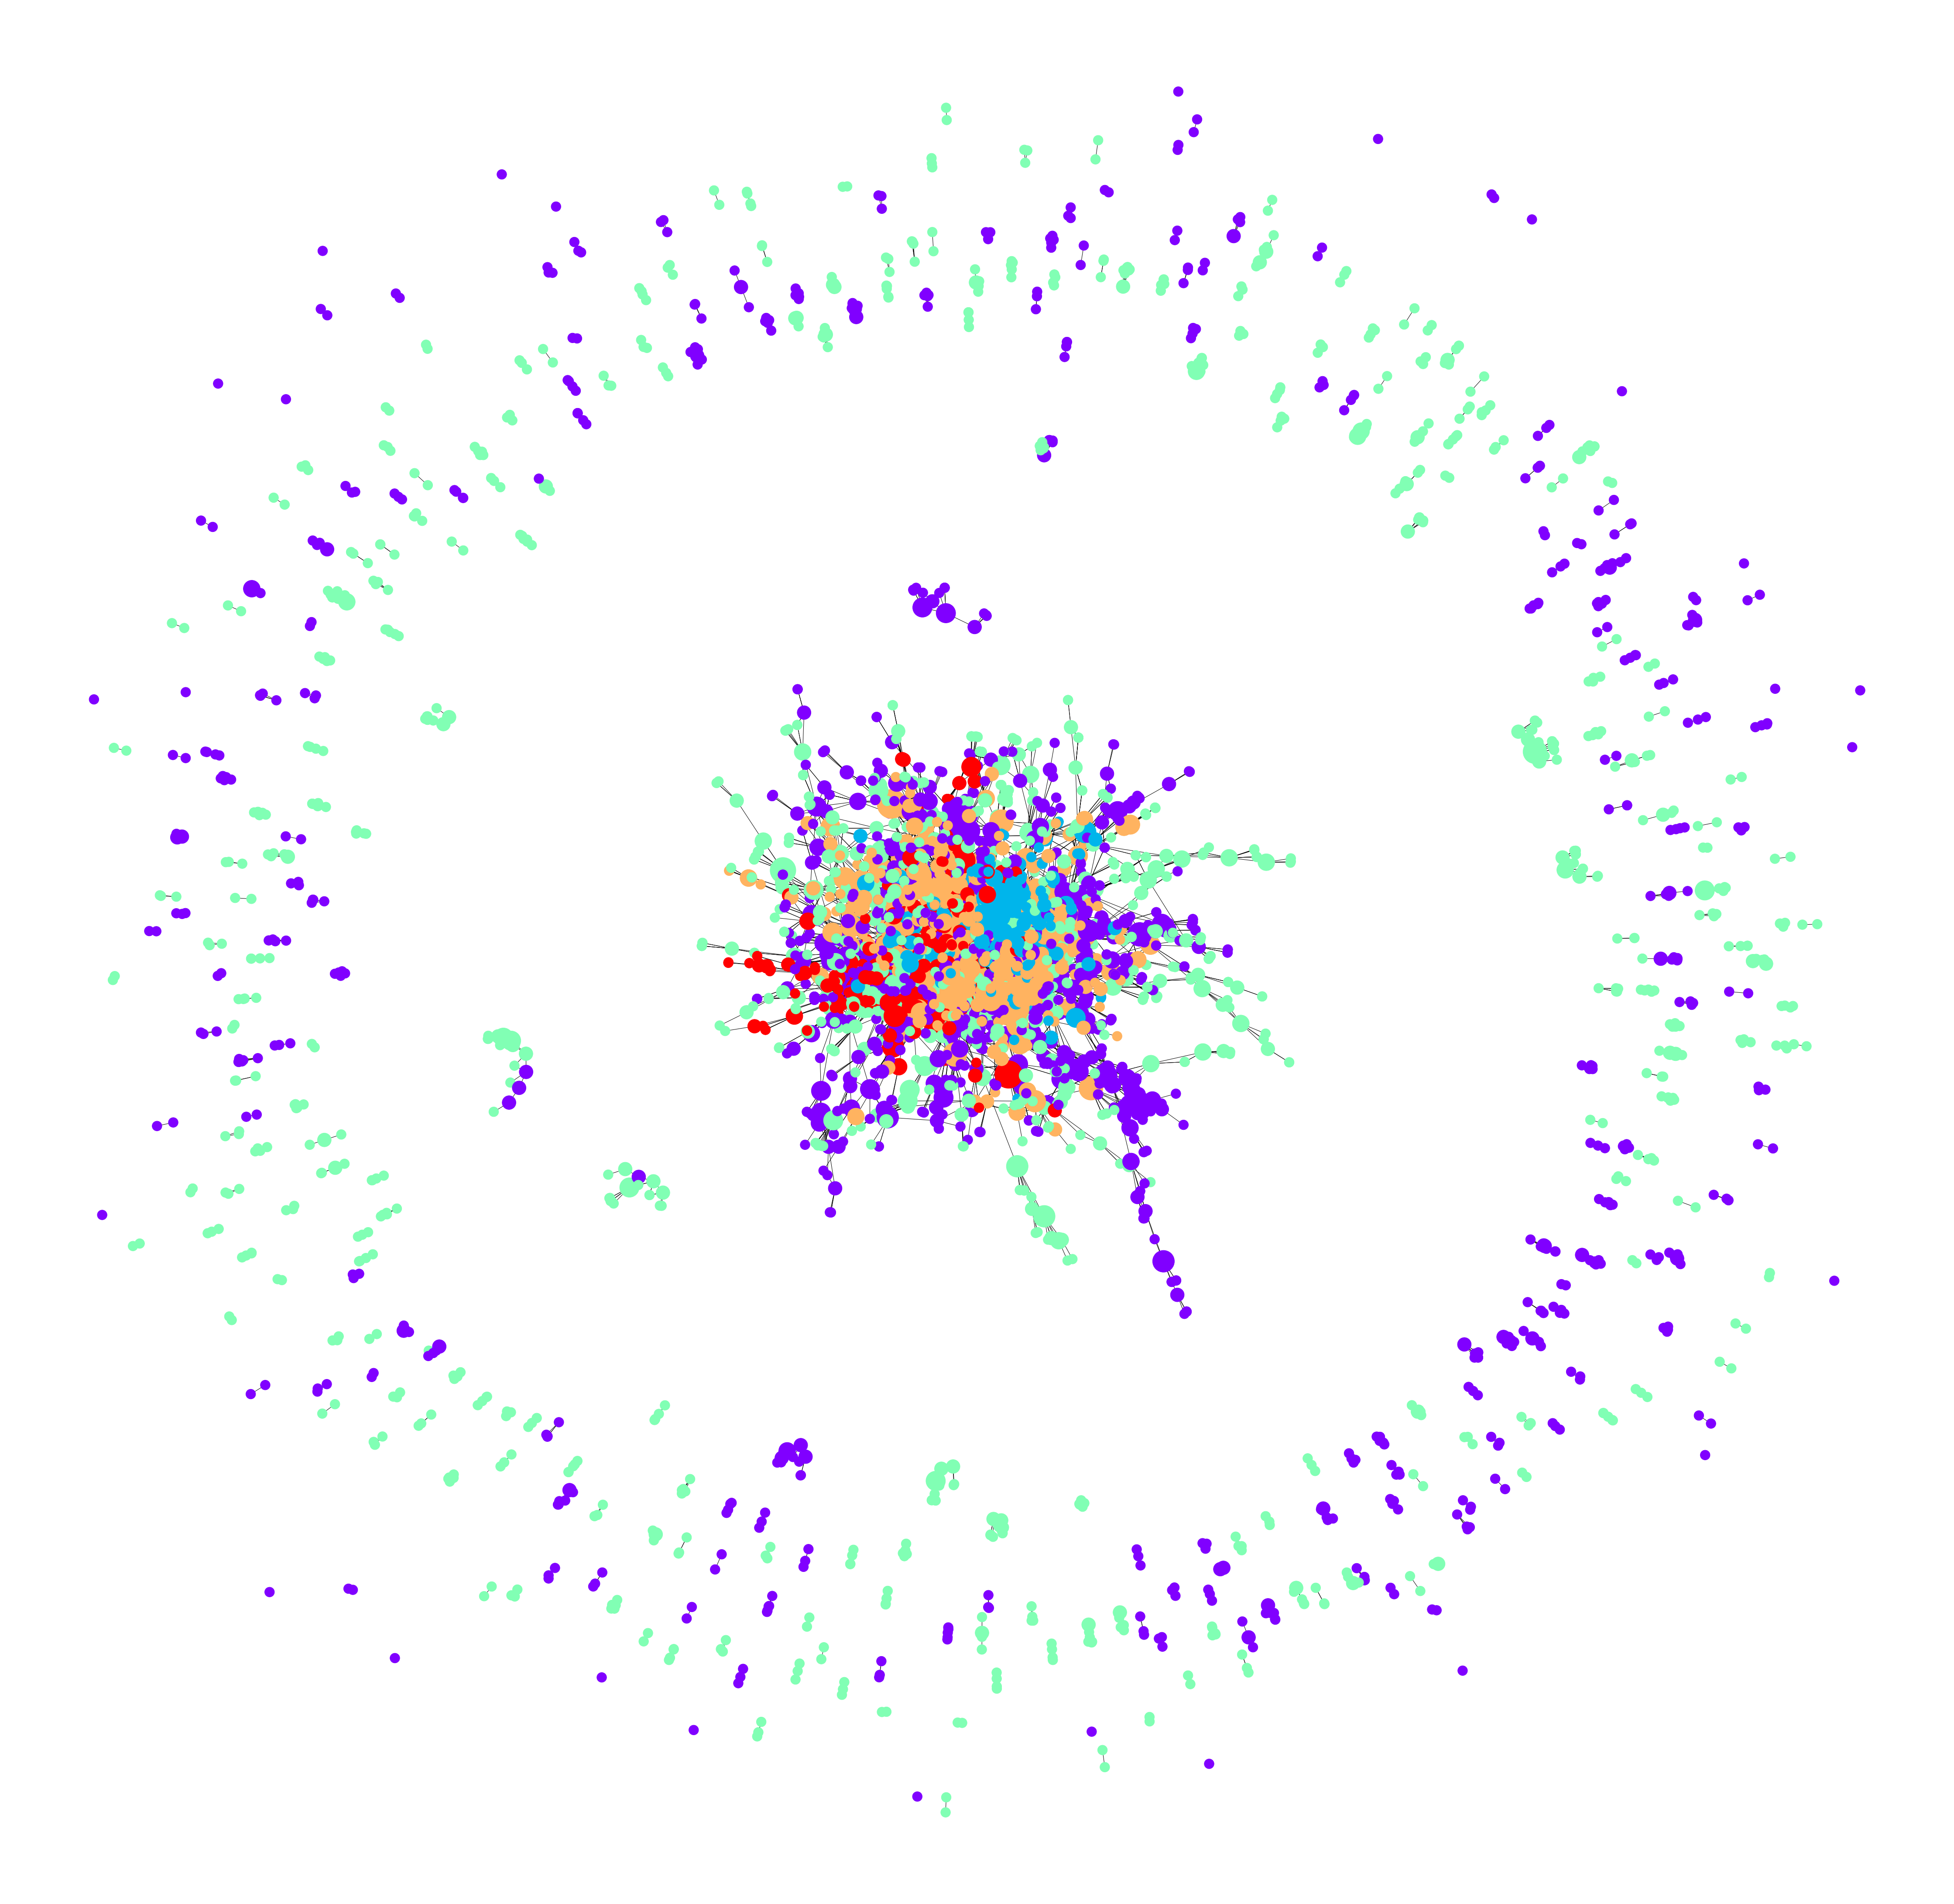

In [18]:
# 그림을 그려줍니다.
plt.figure(figsize=(80, 80))
nx.draw_networkx(G, pos=nx.layout.spring_layout(G), node_size=node_size,
                 node_color=[n[1]['label'] for n in G.nodes(data=True)], with_labels=False,
                 cmap=plt.cm.rainbow
                )
plt.axis('off')
plt.savefig('../image/network_graph_node2vec_kmeans'+years+'.pdf', bbox_inches='tight')
plt.show()